In [3]:
%load_ext autoreload
import sys
import os
import time
import argparse
from collections import OrderedDict
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torchsummary import summary

In [60]:
torch.randint(0, 2, (1, 10))

tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1, 0]])

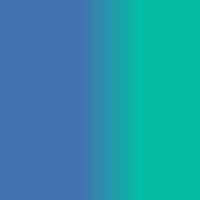

In [50]:
import cairo

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
cr = cairo.Context(surface)
cr.scale(200, 200)

# pat = cairo.LinearGradient(0, 0, 0, 1)
pat = cairo.LinearGradient(0, 0, 1, 0)

for rgb in np.random.uniform(0, 1, (2, 4)):
    pat.add_color_stop_rgba(*rgb, 1)

# pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# pat.add_color_stop_rgba(0, 1, 1, 1, 1)
cr.rectangle(0, 0, 1, 1)
cr.set_source(pat)
cr.fill()

data = np.ndarray(
    shape=(200, 200, 4), dtype=np.uint8, buffer=surface.get_data()
)
im = Image.fromarray(data)
im

/workspace/CRAFT-pytorch/my-src/generator
[<PIL.Image.Image image mode=L size=256x256 at 0x7F863942FAC8>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863941E828>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942F9B0>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942F9E8>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942FB00>] [2, 1, 3, 3, 3] []


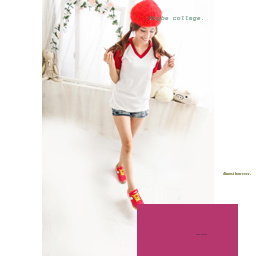

In [53]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src/generator

# from generator.mask import create_mask
import random
from main import Sampler
import blocks as bk

opt = SimpleNamespace()
opt.imsize = 256

# p = {"_a": np.array([1.0]), "_wh": np.array([1.0, 1.0]), "_cxy": np.array([0.5, 0.5]), "repeat": True}
p = {"_a": np.array([1.0]), "_wh": np.array([1.0, 1.0]), "_cxy": np.array([0.5, 0.5])}
bg = bk.Choice([bk.Rectangle(p), bk.Photo("/workspace/CoordConv-pytorch/data/facebook", p)])
text = bk.Choice([
    bk.Line(),
    bk.Group([bk.Line(), bk.Line()]),
    bk.Group([bk.Line(), bk.Line(), bk.Line()]),
])
dec = bk.Rectangle()

# g = bk.Group([bk.Line()])
# cm = bk.CropMask(bk.Line(), bk.Photo("/workspace/CoordConv-pytorch/data/facebook"))
# cm = bk.CropMask(bk.Line(), bk.Rectangle())

texture = bk.Photo("/workspace/transparent-textures/patterns", p)
cm = bk.CropMask(texture, bk.Rectangle({"_a": np.array([1])}))
# cm2 = bk.CropMask(bk.Line(), cm)


s = Sampler([bg, dec,text], opt)
im, (mask_t, cat_t, params_t) = s.sample()

print(mask_t, cat_t, params_t)
im
# mask_t[0]

[[[ 0  0  0  0]
  [ 0  0  0 26]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 8  0  0 32]
  [ 0  0  0  5]]

 [[ 0  0  0 11]
  [ 8  0  0 33]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 8  0  0 33]
  [ 8  0  0 33]]

 [[ 8  0  0  0]
  [ 0  0  0 27]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 7  0  0 34]
  [ 0  0  0 14]]

 ...

 [[ 0  0  0  2]
  [ 0  0  0  0]
  [ 0  0  0  0]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  3]]

 [[ 0  0  0  3]
  [ 0  0  0  0]
  [ 0  0  0  0]
  ...
  [ 0  0  0  0]
  [ 0  0  0  3]
  [ 0  0  0  2]]

 [[ 0  0  0  3]
  [ 0  0  0  0]
  [ 0  0  0  8]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  3]]]


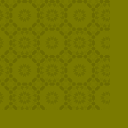

In [181]:
imsize = 128
im = Image.new("RGBA", (imsize, imsize))

# mask = Image.new("RGBA", (imsize, imsize))
draw = ImageDraw.Draw(im)
draw.rectangle((0, 0, imsize, imsize), fill=(122, 122, 0, 255))

p = Image.open("/workspace/transparent-textures/patterns/arab-tile.png")
p = p.convert("RGBA")
p.thumbnail((128, 128))

# print(np.array(p))

im.alpha_composite(p)

# Image.composite(p, im, mask)
# np.array(x)
im

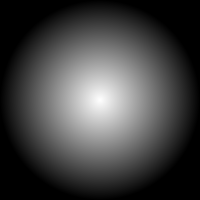

In [226]:
from math import pi

from io import BytesIO
import cairo
import IPython.display

pattern = cairo.MeshPattern()
pattern.begin_patch()
pattern.move_to(0, 0)
pattern.curve_to(30/200, -30/200, 60/200, 30/200, 100/200, 0)
pattern.curve_to(60/200, 30/200, 130/200, 60/200, 100/200, 100/200)
pattern.curve_to(60/200, 70/200, 30/200, 130/200, 0, 100/200)
pattern.curve_to(30/200, 70/200, -30/200, 30/200, 0, 0)
pattern.set_corner_color_rgb(0, 1, 0, 0)
pattern.set_corner_color_rgb(1, 0, 1, 0)
pattern.set_corner_color_rgb(2, 0, 0, 1)
pattern.set_corner_color_rgb(3, 1, 1, 0)
pattern.end_patch()

# svgio = BytesIO()
# with cairo.SVGSurface(svgio, 200, 200) as surface:

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
cr = cairo.Context(surface)
cr.scale(200, 200)

# pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
# for p in np.random.uniform(0, 1, (5, 4)):
#     pat.add_color_stop_rgba(*tuple(p), 1)

pat = cairo.RadialGradient(0.5, 0.5, 0., 0.5, 0.5, 0.5)
# pat.add_color_stop_rgba(0, 0.4, 0.8, 0, 1)
# pat.add_color_stop_rgba(1, 0.4, 0.9, 0.5, 1)
pat.add_color_stop_rgba(0, 1, 1, 1, 1)
pat.add_color_stop_rgba(1, 0, 0, 0, 1)


cr.set_source(pat)
cr.rectangle(0, 0, 1, 1)
cr.fill()
    
#     pat.add_color_stop_rgba(0, 1, 1, 1, 1)
#     pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# cr.set_line_width(0.04)
# pat = cairo.RadialGradient(0.45, 0.4, 0.1,
#                                0.4, 0.4, 0.5)
# pat.add_color_stop_rgba(0, 1, 1, 1, 1)
# pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# cr.set_source(pat)
# cr.arc(0.5, 0.5, 0.3, 0, 1 * pi)
# cr.fill()


# IPython.display.SVG(data=svgio.getvalue())


# width, height = 255, 255
# surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
data = np.ndarray(shape=(200, 200, 4),
                     dtype=np.uint8,
                     buffer=surface.get_data())
# data.shape

im = Image.fromarray(data)
im
# data



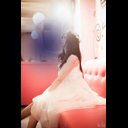

In [2]:
imsize = 128
im = Image.new("RGB", (imsize, imsize))
# font = ImageFont.truetype('font.ttf', 200, encoding='unic')

# draw = ImageDraw.Draw(im)
# draw.rectangle((0, 0, imsize, imsize), fill=(22, 128, 128))
p = Image.open("/workspace/CoordConv-pytorch/data/facebook/60122_528371913855789_1929735771_n.jpg")
p.thumbnail((128, 128))
cx, cy = 64, 64
im.paste(p, (int(cx-p.width/2), int(cy-p.height/2)))
im = im.convert("RGBA")

im2 = Image.new("RGB", (imsize, imsize))
draw = ImageDraw.Draw(im2)
draw.rectangle((0, 0, imsize, imsize), fill=(10, 10, 80))
mask = Image.new("L", (imsize, imsize))
draw = ImageDraw.Draw(mask)
draw.rectangle((30, 30, 60, 60), fill=255)
mask = mask.filter(ImageFilter.GaussianBlur(10))
im2.putalpha(mask)

im.alpha_composite(im2)
im
# im2.mode
# im.mode
# Image.alpha_composite(im, im2)

In [5]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
import glob
# from data import MyDataset
from algo.kmeans import lloyd
from model.vgg import VGGFeatures

opt = SimpleNamespace()
opt.imsize = 64
opt.n_samples = 100
opt.n_layers = 3
opt.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt.root = "../tmp"

model = VGGFeatures().to(opt.device)
model.eval()
trans = transforms.Compose(
    [
        transforms.Resize((opt.imsize, opt.imsize)),
        transforms.ToTensor(),
    ]
)

feats = []
for f in glob.glob(opt.root + "/*"):
    x = trans(Image.open(f))
    x = x.unsqueeze(0)
    x = model(x)
    print(x.shape)
    feats.append(x)
feats = torch.cat(feats, dim=0).detach().numpy()
feats.shape

# idx, ctr = lloyd(feats, 2, opt.device)


# d = MyDataset(opt)
# im, cur_masks, target_mask = d[2]
# # im.shape

# trans(im)
# # trans(target_mask)
# # target_mask.shape


/workspace/CRAFT-pytorch/my-src
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])


(5, 2048)

In [6]:
idx, ctr = lloyd(feats, 2, opt.device)

In [10]:
idx
# ctr.shape

array([1, 0, 0, 1, 1])

In [22]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
from models.craft import CRAFT, vgg16_bn

model = CRAFT()
# x = torch.randn(1, 3, 768, 768)
# m = vgg16_bn(True, False)

/workspace/CRAFT-pytorch/my-src


In [26]:
# m = models.vgg16_bn(pretrained=False).features
# m[0]
x = torch.randn(1, 6, 64, 64)
y = model(x)
# y[0].shape
# summary(m, input_size=(3, 64, 64))

# for i in range(5):
#     print(y[i].shape)
    
y[0].shape

torch.Size([1, 32, 32, 2])

In [ ]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
from generator import blocks as bk

class Sampler:
    def __init__(self, blocks, opt):
        self.blocks = blocks
        self.imsize = opt.imsize

    def sample(self):
        im = Image.new("RGBA", (self.imsize, self.imsize))
        anns = dict()
        labels = []
        for bk in self.blocks:
            bk.sample(self.imsize)
            im.alpha_composite(bk.im)
            for k, v in bk.annotations:
                anns.setdefault(k, []).append(v)
            labels.append(bk.label)
        return im, anns, labels

opt = SimpleNamespace()
opt.imsize = 256

rect = bk.Rectangle()
jpg = bk.Photo("/workspace/CoordConv-pytorch/data/facebook")
text = bk.Text()
bg = bk.Background([bk.Rectangle(), bk.Photo("/workspace/CoordConv-pytorch/data/facebook")])

sp = Sampler([bg, jpg, rect, text], opt)
im, anns, labels = sp.sample()

labels
draw = ImageDraw.Draw(im)
for l in labels:
    draw.rectangle(l['box'], fill=None, outline=(0, 0, 0, 255), width=2)
im

In [ ]:
##### from PIL import Image, ImageDraw
import tesserocr
from tesserocr import PyTessBaseAPI, RIL

im = Image.open('tmp/fb8a7b30bcb8ace3e88565e7617fc87c.jpg')
draw = ImageDraw.Draw(im)
# draw.rectangle((500, 500, 600, 550), fill=255)

print(tesserocr.tesseract_version()) 
print(tesserocr.get_languages())

with PyTessBaseAPI() as api:
    api.SetImage(im)
#     boxes = api.GetComponentImages(RIL.TEXTLINE, True)
    boxes = api.GetComponentImages(RIL.BLOCK, True)
    print('Found {} textline image components.'.format(len(boxes)))
    for i, (_im, box, _, _) in enumerate(boxes):
#         # im is a PIL image object
#         # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
        print(conf, ocrResult)
        draw.rectangle((box['x'], box['y'], box['x']+box['w'], box['y']+box['h']), fill=None, outline=(255, 0, 0))
#         print("Box[{0}]: x={x}, y={y}, w={w}, h={h}, confidence: {1}, text: {2}").format(i, conf, ocrResult, **box)
im

In [ ]:
net = CRAFT()  # initialize
state_dict = torch.load("craft_mlt_25k.pth", map_location="cpu")

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' of dataparallel
    new_state_dict[name] = v

net.load_state_dict(new_state_dict)
net.eval()
None

In [ ]:
image = imgproc.loadImage("data/0e2f315f1f068638932de997005ff9a6.jpg")
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(
        image,
        1280,
        interpolation=cv2.INTER_LINEAR,
        mag_ratio=1.5,
    )
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = imgproc.normalizeMeanVariance(img_resized)
x = torch.from_numpy(x).permute(2, 0, 1)  # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))  # [c, h, w] to [b, c, h, w]

# forward pass
y, _ = net(x)

# make score and link map
# score_text = y[0, :, :, 0].cpu().data.numpy()
# score_link = y[0, :, :, 1].cpu().data.numpy()

# render results (optional)
# render_img = score_text.copy()
# render_img = np.hstack((render_img, score_link))
# ret_score_text = imgproc.cvt2HeatmapImg(render_img)

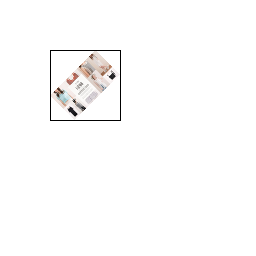

In [52]:
im = Image.new("RGBA", (256, 256))
p = Image.open("/workspace/CRAFT-pytorch/data/0a7c18c4c6c89108254a07b8a4cc1641.jpg").convert('RGBA')
p.thumbnail((64, 64))
p = p.rotate(45, expand=True)

im.paste(p, (50, 50))

# im.bbox
# im

draw = ImageDraw.Draw(im)
draw.rectangle(im.getbbox(), fill=None, outline=(0, 0, 0, 255))
# im.getbbox()
im